<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 2 <br> 
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Si Ben Tran, Yannic Lais, Rami Tarabishi im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>


# Aufgabe aus dem Space
Mini-Challenge 2-C (LE6):
Chatbot

You build a simple chatbot for hotel recommendation (here you can combine with npr and webscraping challenge) or extend the chatbot from the library (auxilio, please take contact with me), with rasa or dialogflow. You can also propose a use case. Important is the way intent are recognized and NER or variables are extracted. Delivery is a report on the use case, interactions and how intents are recognized and variables extracted. Also an error analysis on concrete conversations (confidence of models, explanation of predictions, etc.) should be undertaken. The submission can be done in a group of 2 or 3.


# Aufgabenstellung

Wir haben hier einen simplen ChatBot erstellt, welches die Anfrage des Benutzers entgegennimmt und eine Antwort zurückgibt. Die Anfrage des Benutzers wird durch unsere Preprocessing Pipeline bearbeitet und anschliessend durch ein Machine Learning Model (Kleines Neuronales Netz) klassifiziert - Intent Klassifikation. Anschliessend wird eine zufällige Antwort aus einer Liste von Antworten zurückgegeben. Weiter haben wir versucht die NER (Named Entity Recognition) zu implementieren, welche aber nicht so gut funktioniert hat.

# 1 Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from tqdm import tqdm 

import nltk
# nltk.download('punkt')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import spacy
spacy_nlp = spacy.load("en_core_web_sm")

from src.preprocessing import tokenize, stem, bag_of_words
from src.news_scraper import scrape_srf_links, get_data_for_topics
from src.neuralmodel import NeuralNet 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2 Preprocessor 

## 2.1 Test Tokenizer

In [2]:
word_list = ["believe", "believed", "believes", "believing", "believer"]
print(word_list)
tokenized_word = [tokenize(w) for w in word_list]
print(tokenized_word)

['believe', 'believed', 'believes', 'believing', 'believer']
[['believe'], ['believed'], ['believes'], ['believing'], ['believer']]


## 2.2 Test Stemmer

In [3]:
word_list = ["believe", "believed", "believes", "believing", "believer"]
print(word_list)
stemmed_words = [stem(w) for w in word_list]
print(stemmed_words)

['believe', 'believed', 'believes', 'believing', 'believer']
['believ', 'believ', 'believ', 'believ', 'believ']


## 2.3 Bag of Words

In [4]:
sentence = ["hello", "how", "are", "you"]
words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
bag = bag_of_words(sentence, words)
print(bag)

[0. 1. 0. 1. 0. 0. 0.]


# 3 Create and Load Data

In [5]:
# Scrape srf webpage
url = "https://www.srf.ch"
topic_list = scrape_srf_links(url)
# create data 
get_data_for_topics(topic_list)

Combined JSON file 'data/intents_news.json' created successfully for all topics.


In [6]:
with open('data/intents_news.json', 'r') as f:
    intents_news = json.load(f)

with open('data/intents-scratch.json', 'r') as f:
    intents = json.load(f)

# combine intents_news with intens
intents["intents"].extend(intents_news["intents"])

# export intents formmated as json
with open('data/intents.json', 'w') as outfile:
    json.dump(intents, outfile, indent=4)

In [7]:
all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents["intents"]:
    tag = intent["tag"]
    # add to tag list
    tags.append(tag)
    for pattern in intent["patterns"]:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

print(all_words)
print(tags)
print(xy)

['Hello', ',', 'my', 'name', 'is', 'Hi', ',', 'I', "'m", 'Hey', ',', 'I', 'go', 'by', 'I', 'am', 'Greetings', ',', 'call', 'me', 'You', 'can', 'call', 'me', 'They', 'call', 'me', 'My', 'name', "'s", 'I', "'d", 'like', 'to', 'introduce', 'myself', ',', 'I', "'m", 'Allow', 'me', 'to', 'introduce', 'myself', ',', 'I', 'am', 'I', 'go', 'by', 'the', 'name', 'People', 'know', 'me', 'as', 'Hi', 'Hey', 'How', 'are', 'you', 'Is', 'anyone', 'there', '?', 'Hello', 'Good', 'day', 'Whats', 'up', 'How', 'are', 'you', 'doing', 'Howdy', 'Hi', 'there', 'Hola', 'Good', 'morning', 'Good', 'afternoon', 'Good', 'evening', 'It', 'is', 'nice', 'to', 'meet', 'you', 'Bye', 'See', 'you', 'later', 'Goodbye', 'Nice', 'chatting', 'to', 'you', ',', 'bye', 'Till', 'next', 'time', 'Have', 'a', 'nice', 'day', 'See', 'you', '!', 'Later', '!', 'Goodbye', '!', 'I', "'m", 'off', '!', 'That', "'s", 'all', 'for', 'now', '.', 'See', 'you', 'soon', '!', 'I', "'ve", 'got', 'to', 'get', 'going', '.', 'Bye', '!', 'It', 'was', 'n

# 3.1 Preprocessing Intent Data

In [8]:
# stem and lower each word and remove duplicates and sort
ignore_words = ["?", "!", ".", ","]
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

436 patterns
46 tags: ['arbeitsrecht', 'decodar-nossa-cultura', 'delivery', 'dialog', 'film-serien', 'funny', 'fussball', 'gesundheit', 'goodbye', 'greeting', 'hoerspiele', 'international', 'introduction', 'items', 'jobs.srf.ch', 'kassensturz-espresso', 'kunst', 'literatur', 'mehr-sport', 'mensch', 'musik', 'natur-tiere', 'payments', 'podcasts', 'radio', 'school', 'schweiz', 'ski-alpin', 'startseite', 'thanks', 'themen', 'tv', 'video', 'website-und-apps', 'wetter', 'wirtschaft', 'woerterbuch', 'www.radioswissclassic.ch', 'www.radioswissjazz.ch', 'www.radioswisspop.ch', 'www.rsi.ch', 'www.rtr.ch', 'www.rts.ch', 'www.srf.ch', 'www.srgssr.ch', 'www.swissinfo.ch']
168 unique stemmed words: ["'d", "'m", "'s", "'ve", 'a', 'about', 'accept', 'afternoon', 'all', 'allow', 'am', 'amex', 'ani', 'anyon', 'appl', 'arbeitsrecht', 'are', 'as', 'awesom', 'bitcoin', 'bunch', 'by', 'bye', 'call', 'can', 'card', 'cash', 'chat', 'convers', 'credit', 'crypto', 'cryptocurr', 'day', 'decodar-nossa-cultura', 

## 3.2 Train and Test Data

In [9]:
X_train = []
y_train = []

for pattern_sentence, tag in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

(436, 168)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(436,)
[12 12 12 12 12 12 12 12 12 12 12 12  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 29 29 29
 29 29 29 29 29 29 29 29 29 13 13 13 13 13 13 13 13 13 13 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22  2  2  2  2  2  2  2  5  5  5  5  5  7  7
  7  7  7  7  7  7  7 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21
 21 45 45 45 45 45 45 45 45 45 15 15 15 15 15 15 15 15 15 26 26 26 26 26
 26 26 26 26 34 34 34 34 34 34 34 34 34 32 32 32 32 32 32 32 32 32  0  0
  0  0  0  0  0  0  0 17 17 17 17 17 17 17 17 17 27 27 27 27 27 27 27 27
 27 16 16 16 16 16 16 16 16 16 39 39 39 39 39 39 39 39 39 35 35 35 35 35
 35 35 35 35 38 38 38 38 38 38 38 38 38 14 14 14 14 14 14 14 14 14 19 19
 19 19 19 19 19 19 19 30 30 30 30 30 30 30 30 30 28 28 28 28 28 28 28 28
 28 41 41 41 41 41 41 4

## 3.3 Create DataLoader 

In [10]:
class ChatDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [11]:
# define Batch size
batch_size = 2

# Create dataset
dataset = ChatDataset(X_train=X_train, y_train=y_train)
# create DataLoader
train_loader = DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

print(dataset.n_samples)
print(dataset.x_data)
print(dataset.y_data)

# get first batch
for first_batch in train_loader:
    break
# get first training batch
first_batch_inputs = first_batch[0]
first_batch_labels = first_batch[1]

print(first_batch_inputs.shape)
print(first_batch_labels.shape)

436
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[12 12 12 12 12 12 12 12 12 12 12 12  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 29 29 29
 29 29 29 29 29 29 29 29 29 13 13 13 13 13 13 13 13 13 13 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22  2  2  2  2  2  2  2  5  5  5  5  5  7  7
  7  7  7  7  7  7  7 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21
 21 45 45 45 45 45 45 45 45 45 15 15 15 15 15 15 15 15 15 26 26 26 26 26
 26 26 26 26 34 34 34 34 34 34 34 34 34 32 32 32 32 32 32 32 32 32  0  0
  0  0  0  0  0  0  0 17 17 17 17 17 17 17 17 17 27 27 27 27 27 27 27 27
 27 16 16 16 16 16 16 16 16 16 39 39 39 39 39 39 39 39 39 35 35 35 35 35
 35 35 35 35 38 38 38 38 38 38 38 38 38 14 14 14 14 14 14 14 14 14 19 19
 19 19 19 19 19 19 19 30 30 30 30 30 30 30 30 30 28 28 28 28 28 28 28 28
 28 41 41 41 41 41 41 41 41 41  1  1 

# 4 Model

Hier in diesem Abschnitt importieren wir unsere unterschiedlichen Modelle die wir für die Klassifizierung der Intents verwenden wollen.

# 4.1 Define Hyperparameters

In [12]:
# Hyper-parameters
batch_size = batch_size
num_epochs = 100
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 50
output_size = len(tags)
print(input_size, output_size)


168 46


## 4.2 Model Instanzieren

In [13]:
neural_net = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=learning_rate)

# 5 Train Model

In [14]:
# Train the model
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    # Wrap the train_loader with tqdm to create a progress bar
    for words, labels in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)

        # Forward pass
        outputs = neural_net(words)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Print loss after every 10 epochs
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}")


print(f"final loss: {loss.item():.8f}")


Training Progress:  10%|█         | 10/100 [00:05<00:51,  1.76epoch/s]

Epoch [10/100], Loss: 0.00115322


Training Progress:  20%|██        | 20/100 [00:11<00:44,  1.79epoch/s]

Epoch [20/100], Loss: 0.00030275


Training Progress:  30%|███       | 30/100 [00:18<00:53,  1.31epoch/s]

Epoch [30/100], Loss: 0.00002664


Training Progress:  40%|████      | 40/100 [00:28<00:55,  1.07epoch/s]

Epoch [40/100], Loss: 0.00001103


Training Progress:  50%|█████     | 50/100 [00:47<03:00,  3.62s/epoch]

Epoch [50/100], Loss: 0.00000167


Training Progress:  60%|██████    | 60/100 [00:58<00:33,  1.20epoch/s]

Epoch [60/100], Loss: 0.00000054


Training Progress:  70%|███████   | 70/100 [01:05<00:20,  1.47epoch/s]

Epoch [70/100], Loss: 0.00000006


Training Progress:  80%|████████  | 80/100 [01:14<00:16,  1.22epoch/s]

Epoch [80/100], Loss: 0.00000006


Training Progress:  90%|█████████ | 90/100 [01:24<00:09,  1.10epoch/s]

Epoch [90/100], Loss: 0.00000006


Training Progress: 100%|██████████| 100/100 [01:33<00:00,  1.07epoch/s]

Epoch [100/100], Loss: 0.00014662
final loss: 0.00014662


## 5.1 Save Model

In [15]:
data = {
    "model_state": neural_net.state_dict(),
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "all_words": all_words,
    "tags": tags,
}

FILE = "model/mlp_weights.pth"
torch.save(data, FILE)

print(f"training complete. file saved to {FILE}")

training complete. file saved to model/mlp_weights.pth


# 6 Load trained Model

In [16]:
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data["all_words"]
tags = data["tags"]
model_state = data["model_state"]

neural_net = NeuralNet(input_size, hidden_size, output_size).to(device)
neural_net.load_state_dict(model_state)
neural_net.eval()


NeuralNet(
  (l1): Linear(in_features=168, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=50, bias=True)
  (l3): Linear(in_features=50, out_features=46, bias=True)
  (relu): ReLU()
)

# 7 Named Entity Recognition

In [17]:
# test NER
text = "I like Elon Musk, but who is Donald Trump? or where is New York?"
doc = spacy_nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

Elon Musk PERSON
Donald Trump PERSON
New York GPE


In [18]:
# Function to extract persons from user input using SpaCy NER
def extract_persons(text):
    doc = spacy_nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    return persons

# 8 ChatBot

In [19]:
print("Heutige News Topic:", scrape_srf_links(url))

Heutige News Topic: {'gesundheit', 'musik', 'natur-tiere', 'www.swissinfo.ch', 'kassensturz-espresso', 'schweiz', 'wetter', 'video', 'arbeitsrecht', 'literatur', 'ski-alpin', 'kunst', 'www.radioswisspop.ch', 'wirtschaft', 'www.radioswissjazz.ch', 'jobs.srf.ch', 'eishockey', 'mensch', 'themen', 'startseite', 'www.rtr.ch', 'decodar-nossa-cultura', 'dialog', 'radio', 'woerterbuch', 'www.rsi.ch', 'film-serien', 'www.srgssr.ch', 'www.srf.ch', 'www.rts.ch', 'international', 'mehr-sport', 'podcasts', 'fussball', 'tv', 'hoerspiele', 'website-und-apps', 'school', 'www.radioswissclassic.ch'}


In [20]:
bot_name = "Stupid Bounty Hunter Bot"
print(f"Hey my name is {bot_name}, I am your news Chatbot Assistent\
      \nand can fetch you the newest topic on srf for you.\
      \nBy the way, who are you? \n type 'quit' to exit")

while True:
    sentence = input("You: ")
    print("User Input:", sentence)
    if sentence == "quit":
        break

    # Extract persons from the user input
    persons = extract_persons(sentence)

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = neural_net(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]

    if prob.item() > 0.75:
        for intent in intents["intents"]:
            if tag == intent["tag"]:
                # Add NER results to the response
                response = np.random.choice(intent['responses'])
                if persons:
                    response = response.replace("{persons}", ", ".join(persons))
                else:
                    response = response.replace("{persons}", "")
                print(f"{bot_name}: {response}")
    else:
        print(f"{bot_name}: I do not understand...")


Hey my name is Stupid Bounty Hunter Bot, I am your news Chatbot Assistent      
and can fetch you the newest topic on srf for you.      
By the way, who are you? 
 type 'quit' to exit
User Input: quit


# 9 Example Konversation

Diese Konversation wurde am 19.12.2023 geführt.

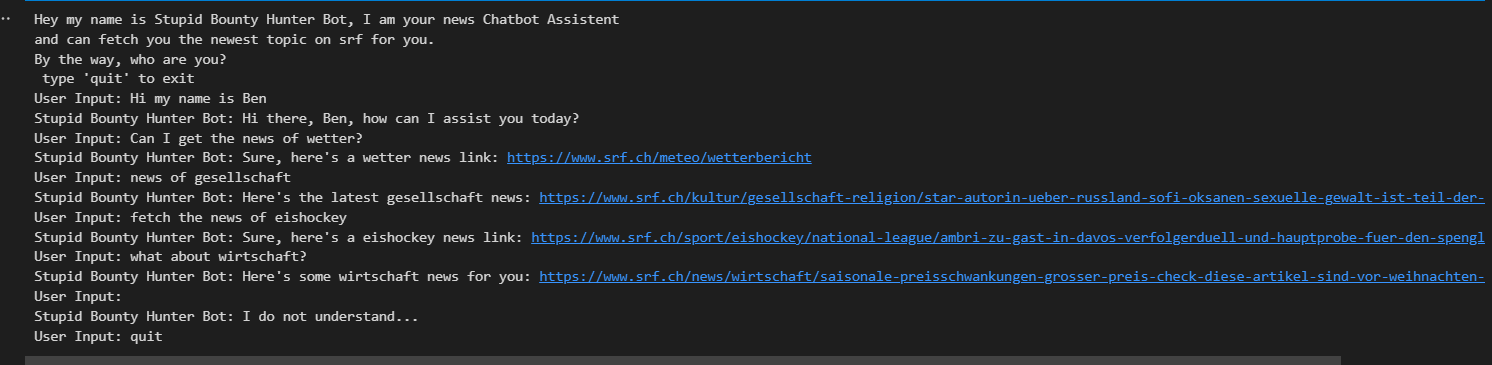